# Synthetic Electronic Health Record Data (SEHRD) package demo
This notebook demonstrates SEHRD package functionality on a toy dataset.

## Setup

### Import python and SEHRD modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from preprocessor import preprocessor
from corgan import corgan
from realism import realism
from privacy import privacy

### Set parameters for the toy dataset and demo

In [2]:
# toy dataset
n = 1000
count_min = 5
count_max = 19
constant_value = 'helloworld'
binary_A = 'A'
binary_B = 'B'
categorical_values = ['X','Y','Z']

# synthetic data generation and validation
n_gen = n
outcome = 'binary01'

# sehrd objects
pre = preprocessor(missing_value=-99999)
rea = realism(missing_value=-99999)
pri = privacy()
cor = corgan()

### Generate the toy dataset

In [3]:
names = ['constant','binary01', 'binaryAB', 'categorical','count','continuous']
v_constant = np.full(shape=n, fill_value=constant_value)
v_binary01 = np.random.randint(low=0, high=2, size=n)
v_binaryAB = np.concatenate((np.full(shape=n-1, fill_value=binary_A), np.array([binary_B])))
v_categorical = np.random.choice(categorical_values, size=n)
v_count = np.random.randint(low=count_min, high=count_max+1, size=n)
v_continuous = np.random.random(size=n)
x = np.column_stack((v_constant, v_binary01, v_binaryAB, v_categorical, v_count, v_continuous))
print(x)

[['helloworld' '0' 'A' 'Y' '6' '0.9218691507903986']
 ['helloworld' '0' 'A' 'Z' '16' '0.9070388200743605']
 ['helloworld' '0' 'A' 'Z' '6' '0.32083866636421954']
 ...
 ['helloworld' '1' 'A' 'X' '14' '0.6427227159526024']
 ['helloworld' '1' 'A' 'X' '17' '0.2591951141255239']
 ['helloworld' '1' 'B' 'Y' '7' '0.5518645575242592']]


## Preprocessing

### Save metadata for restoring data format after synthetic data generation

In [4]:
m = pre.get_metadata(x=x, header=names)
print('var_name, var_type, min, max, zero, one')
print(m)

var_name, var_type, min, max, zero, one
[('constant', 'constant', 0.00000000e+00,  0.        , 'helloworld', '')
 ('binary01', 'binary', 0.00000000e+00,  0.        , '0', '1')
 ('binaryAB', 'binary', 0.00000000e+00,  0.        , 'A', 'B')
 ('categorical', 'categorical', 0.00000000e+00,  0.        , '', '')
 ('count', 'count', 5.00000000e+00, 19.        , '', '')
 ('continuous', 'continuous', 1.42370504e-04,  0.99947208, '', '')]


### Encode raw data matrix in preparation for training synthetic data generator
Note that count and continuous variables have been scaled between 0 and 1 while constant, categorical, and binary have been one-hot encoded.

In [5]:
d = pre.get_discretized_matrix(x, m, names)
print('Formatted matrix:')
print(d['x'])
print('\nHeader for formatted matrix:')
print(d['header'])

Formatted matrix:
[[0.         0.         0.         ... 0.         0.07142857 0.92234502]
 [0.         0.         0.         ... 1.         0.78571429 0.90750474]
 [0.         0.         0.         ... 1.         0.07142857 0.3209114 ]
 ...
 [0.         1.         0.         ... 0.         0.64285714 0.64301135]
 [0.         1.         0.         ... 0.         0.85714286 0.2592265 ]
 [0.         1.         1.         ... 0.         0.14285714 0.55209225]]

Header for formatted matrix:
['constant' 'binary01' 'binaryAB' 'categorical__X' 'categorical__Y'
 'categorical__Z' 'count' 'continuous']


## Generation

### Train CorGAN model 

In [6]:
model = cor.train(x=d['x'], n_cpu=15)

### Generate synthetic samples

In [7]:
s = cor.generate(model, n_gen)
print(s)

[[7.90974591e-03 5.30771492e-03 3.80635285e-03 ... 3.21569294e-01
  6.31566048e-01 9.93109941e-01]
 [2.03271490e-03 8.65365624e-01 1.58252439e-03 ... 1.54353608e-03
  4.70247984e-01 1.61064335e-03]
 [4.37405379e-03 8.84063303e-01 4.10446618e-03 ... 5.49250835e-05
  4.65826541e-01 3.61446261e-01]
 ...
 [3.38098151e-03 3.44019546e-03 4.46706498e-03 ... 3.76363099e-03
  4.02297564e-02 1.47007396e-02]
 [6.20323513e-03 9.86800313e-01 6.57697674e-03 ... 7.93429255e-01
  7.63886750e-01 9.88481998e-01]
 [1.94949154e-02 3.87154967e-01 1.11035155e-02 ... 9.95165825e-01
  5.88445365e-01 9.91517961e-01]]


### Use metadata to restore original formatting

In [8]:
f = pre.restore_matrix(s=s, m=m, header=d['header'])
print('Synthetic samples:')
print(f['x'])
print('\nReal samples:')
print(x)

Synthetic samples:
[['helloworld' '0' 'A' 'X' '14.0' '0.9925866389615972']
 ['helloworld' '0' 'A' 'X' '12.0' '0.0017519342502336668']
 ['helloworld' '0' 'A' 'X' '12.0' '0.36134635759944195']
 ...
 ['helloworld' '0' 'A' 'X' '6.0' '0.014833256369307142']
 ['helloworld' '0' 'A' 'Z' '16.0' '0.9879617979929435']
 ['helloworld' '0' 'A' 'Z' '13.0' '0.9909957255950554']]

Real samples:
[['helloworld' '0' 'A' 'Y' '6' '0.9218691507903986']
 ['helloworld' '0' 'A' 'Z' '16' '0.9070388200743605']
 ['helloworld' '0' 'A' 'Z' '6' '0.32083866636421954']
 ...
 ['helloworld' '1' 'A' 'X' '14' '0.6427227159526024']
 ['helloworld' '1' 'A' 'X' '17' '0.2591951141255239']
 ['helloworld' '1' 'B' 'Y' '7' '0.5518645575242592']]


## Realism

### Compare univariate frequency for real and synthetic features

In [9]:
res_uni = rea.validate_univariate(r=d['x'], s=s, header=d['header'], discretized=True)
corr_uni = np.corrcoef(x=res_uni['frq_r'], y=res_uni['frq_s'])[0,1]
print('Correlation between feature frequencies =',np.round(corr_uni,2))

Correlation between feature frequencies = 1.0


Plot the synthetic and real feature frequencies for each feature...

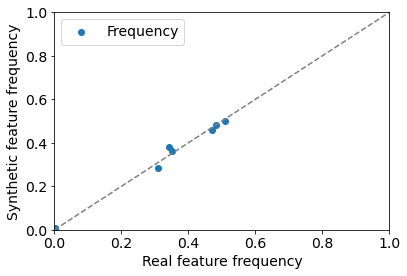

In [10]:
fontsize = 14
fig, ax1 = plt.subplots(1,1)
ax1.plot([0,1],[0,1], color="gray", linestyle='--')
ax1.scatter(res_uni['frq_r'], res_uni['frq_s'], label='Frequency')
ax1.set_xlabel('Real feature frequency', fontsize=fontsize)
ax1.set_ylabel('Synthetic feature frequency', fontsize=fontsize)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.tick_params(axis='x', labelsize=fontsize)
ax1.tick_params(axis='y', labelsize=fontsize)
ax1.legend(fontsize=fontsize)

### Compare predictive performance
* Real: use real dataset to train predictive model and test on a separate real dataset
* GAN-train: use synthetic dataset to train predictive model and test on a real dataset
*GAN-test: use real dataset to train predictive model and test on the synthetic dataset

In [11]:
print('Extract outcome \'', outcome,'\' from real and synthetic datasets', sep='')

Extract outcome 'binary01' from real and synthetic datasets


In [12]:
r = d['x']

idx_outcome = np.where(d['header'] == outcome)
y_r = np.reshape(np.round(np.reshape(r[:,idx_outcome], newshape=(len(r),1))).astype(int), len(r))
y_s = np.reshape(np.round(np.reshape(s[:,idx_outcome], newshape=(len(s),1))).astype(int), len(s))
x_r = np.delete(r, idx_outcome, axis=1)
x_s = np.delete(s, idx_outcome, axis=1)

print('Real dataset dimensions:',x_r.shape)
print('Synthetic dataset dimensions:',x_s.shape)

Real dataset dimensions: (1000, 7)
Synthetic dataset dimensions: (1000, 7)


Train model for each validation test

In [13]:
n_epoch = 20
model_type='lr'

res_gan_real = rea.gan_train(x_r, y_r, x_r, y_r, n_epoch=n_epoch, model_type=model_type)
res_gan_train = rea.gan_train(x_s, y_s, x_r, y_r, n_epoch=n_epoch, model_type=model_type)
res_gan_test = rea.gan_test(x_s, y_s, x_r, y_r, n_epoch=n_epoch, model_type=model_type)

Plot resulting ROC curves

Text(0, 0.5, 'True positive rate')

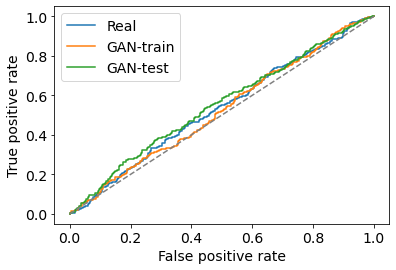

In [14]:
fontsize = 14
fig, ax3 = plt.subplots(1,1)
ax3.plot(res_gan_real['roc'][0], res_gan_real['roc'][1], label="Real")
ax3.plot(res_gan_train['roc'][0], res_gan_train['roc'][1], label="GAN-train")
ax3.plot(res_gan_test['roc'][0], res_gan_test['roc'][1], label="GAN-test")
ax3.plot([0,1],[0,1], color="gray", linestyle='--')
ax3.tick_params(axis='x', labelsize=fontsize)
ax3.tick_params(axis='y', labelsize=fontsize)
ax3.legend(fontsize=fontsize)
ax3.set_xlabel('False positive rate', fontsize=fontsize)
ax3.set_ylabel('True positive rate', fontsize=fontsize)

## Privacy

## Nearest neighbors
Ensure that synthetic dataset is not a copy of the real dataset by comparing distances between pairs of real and synthetic samples
* Real-real: distance between randomly selected pairs of real samples
* Real-synthetic: distance between pairs of real and synthetic samples
* Real-probabilistic: distance between a real sample and sampled binary vector where each column is sampled from a binomial where the frequency equals that in the real training set
* Real-random: distance between a real sample and a randomly sampled binary vector

In [15]:
n_nn_sample = 100
dist_metric = 'euclidean'
n_decimal=2

idx_r = np.random.randint(low=0, high=len(r), size=min((len(r), n_nn_sample)))
idx_s = np.random.randint(low=0, high=len(s), size=min((len(s), n_nn_sample)))
res_nn = pri.assess_memorization(r[idx_r,:], s[idx_s,:], metric=dist_metric)

print('Mean nearest neighbor distance: ')
print('  > Real-real:\t\t'+str(np.round(np.mean(res_nn['real']),n_decimal)))
print('  > Real-synthetic:\t'+str(np.round(np.mean(res_nn['synth']),n_decimal)))
print('  > Real-probabilistic: '+str(np.round(np.mean(res_nn['prob']),n_decimal)))
print('  > Real-random:\t'+str(np.round(np.mean(res_nn['rand']),n_decimal)))

Mean nearest neighbor distance: 
  > Real-real:		0.13
  > Real-synthetic:	0.35
  > Real-probabilistic: 0.44
  > Real-random:	0.65


Plot distributions for nearest neighbor distances

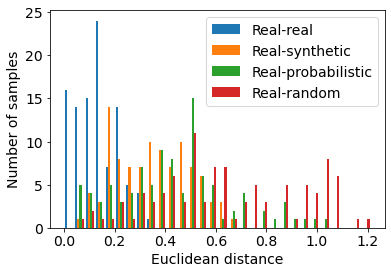

In [16]:
fontsize = 14
fig, ax2 = plt.subplots(1,1)
ax2.hist((res_nn['real'], res_nn['synth'], 
          res_nn['prob'], res_nn['rand']),
         bins=30, 
         label = ['Real-real','Real-synthetic','Real-probabilistic','Real-random'])
ax2.set_xlabel(dist_metric.capitalize()+' distance', fontsize=fontsize)
ax2.set_ylabel('Number of samples', fontsize=fontsize)
ax2.tick_params(axis='x', labelsize=fontsize)
ax2.tick_params(axis='y', labelsize=fontsize)
ax2.legend(fontsize=fontsize)
